This notebook pertains code allowing a user to input files corresponding to ECG data in binary form and produces visual plots of the ECG's for the v1-v6 channels.

In [1]:
#necessery imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct #for binary conversion
from scipy.signal import butter, filtfilt #for data processing

In [2]:
def read_binary_file(file_path):
    '''
    function to read binary data from file and store in python list, adapted using ChatGPT
    '''
    with open(file_path, 'rb') as file:
        binary_data = []
        while True:
            binary_int = file.read(2)# Assumes each number is 16-bit, read 2 bytes (16 bits) from the file as a binary integer
            if not binary_int:
                break# end of file reached
            value = struct.unpack('<h', binary_int)[0]
            binary_data.append(value)
    return binary_data

def create_lead_dataframe(file_path, lead_name):
    '''
    Function that takes the file and a string relating to header of column of data set (the lead) and returns complete column.
    Converts y-axis from Adu (something units) to mV
    '''
    binary_data = read_binary_file(file_path)
    lead_data = [value / 2000 for value in binary_data]
    lead_df = pd.DataFrame({lead_name: lead_data})
    return lead_df

def create_ecg_dataframe(file_path, lead_names):
    '''
    Function to create complete ecg data set by combing all the columns
    '''
    lead_dataframes = [create_lead_dataframe(file_path, lead_name) for lead_name in lead_names]
    ecg_dataframe = pd.concat(lead_dataframes, axis=1)
    return ecg_dataframe

def add_timestamps(ecg_dataframe, sampling_rate):
    '''
    Function to add time column to data set given the sampling rate of the data
    '''
    total_samples = len(ecg_dataframe)
    time_values = np.arange(0, total_samples) / sampling_rate
    ecg_dataframe["Time (s)"] = time_values
    return ecg_dataframe

In [3]:
example_file = 'ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re.dat'
lead_names = ["i", "ii", "iii", "avr", "avl", "avf", "v1", "v2", "v3", "v4", "v5", "v6"]
freq = 1000 #Hz (sampling frequency)

example_ecg_df = add_timestamps(create_ecg_dataframe(example_file, lead_names), freq)
example_ecg_df

,i,ii,iii,avr,avl,avf,v1,v2,v3,v4,v5,v6,Time (s)
0,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,-0.2445,0.000
1,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,-0.2290,0.001
2,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.0155,0.002
3,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.2370,0.003
4,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,-0.1300,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
460795,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,0.0820,460.795
460796,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,0.0590,460.796
460797,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,-0.0840,460.797
460798,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,-0.1245,460.798


Can see above that this creates a database where the data is copied for all 12 leads and a time column has been added. This is not yet particularly useful as I need to be able to look at the required data for each lead.

In [4]:
def create_v_channel_dataframe(ecg_dataframe):
    '''
    function to create a dictionary that allows access to the correct data along with its time stamp through the name of the lead
    '''
    dt = int(len(ecg_dataframe)/12) #calculate by how much to split the data
    v_channel_dataframes = {}
    for i, channel_name in enumerate(["i", "ii", "iii", "avr", "avl", "avf", "v1", "v2", "v3", "v4", "v5", "v6"]):
        selected_channel_df = ecg_dataframe[channel_name].iloc[i * dt:(i + 1) * dt]
        v_channel_dataframes[channel_name] = selected_channel_df
    return v_channel_dataframes




v_channel_df = create_v_channel_dataframe(example_ecg_df)
v_channel_df

{'i': 0       -0.2445
 1       -0.2290
 2        0.0155
 3        0.2370
 4       -0.1300
           ...  
 38395    0.1580
 38396    0.1725
 38397    0.1065
 38398    0.0070
 38399   -0.0065
 Name: i, Length: 38400, dtype: float64,
 'ii': 38400   -0.1045
 38401   -0.2625
 38402   -0.1580
 38403    0.1835
 38404    0.0270
           ...  
 76795   -0.1310
 76796    0.0090
 76797    0.1000
 76798    0.1120
 76799    0.0980
 Name: ii, Length: 38400, dtype: float64,
 'iii': 76800    -0.0840
 76801    -0.0090
 76802     0.0750
 76803     0.0465
 76804    -0.0795
            ...  
 115195   -0.2520
 115196   -0.2080
 115197   -0.0685
 115198   -0.0065
 115199    0.0060
 Name: iii, Length: 38400, dtype: float64,
 'avr': 115200   -0.0940
 115201   -0.0605
 115202    0.0335
 115203    0.0770
 115204   -0.0630
            ...  
 153595    0.0640
 153596    0.0670
 153597    0.0590
 153598    0.0200
 153599    0.0490
 Name: avr, Length: 38400, dtype: float64,
 'avl': 153600   -0.0085
 153601   -

Can see dictionary above.

Now applying butterworth filter.

In [5]:

cutoff_frequency = 40  # Cutoff frequency in Hz
order = 3 #order of 

def butter_filter(data_channel, cutoff_freq, order, sample_freq):
    b, a = butter(order, cutoff_freq / (0.5*sample_freq), btype = 'low', analog = False)
    filtered_data = filtfilt(b, a, data_channel)
    return filtered_data
                  
i = 6
v1_filtered = butter_filter(v_channel_df["v" + str(i)], cutoff_frequency, order, freq) # example

Now we have all the necessary functions for calculations want to be able to plot all six leads and their filters for a given file from the data base.

In [6]:
def plot_raw_and_filtered(file, lead_names, cut_off_freq, order, sample_freq):
    ecg_df = add_timestamps(create_ecg_dataframe(file, lead_names), sample_freq)
    v_channel_df = create_v_channel_dataframe(ecg_df)
    dt = int(len(ecg_df)/12)
    
    
    fig1, axes = plt.subplots(3, 2, figsize = (16, 16))
    j = 0
    k = 0
    for i in range(0, 6):        
        
        if i == 0:
            k = 0
            
        elif i % 2 == 0 and i != 0:
            j += 1
            k = 0
            
        else:
            k= 1
            
        filt_dat = butter_filter(v_channel_df["v"+str(i+1)], cut_off_freq, order, sample_freq)
        axes[j, k].plot(ecg_df["Time (s)"].iloc[6*dt+i*dt:6*dt+(i+1)*dt], v_channel_df["v"+str(i+1)], label="Original v" + str(i+1))
        axes[j, k].plot(ecg_df["Time (s)"].iloc[6*dt+i*dt:6*dt+(i+1)*dt], filt_dat, label="Filtered v" + str(i+1))
        axes[j, k].legend()

    return None

        

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

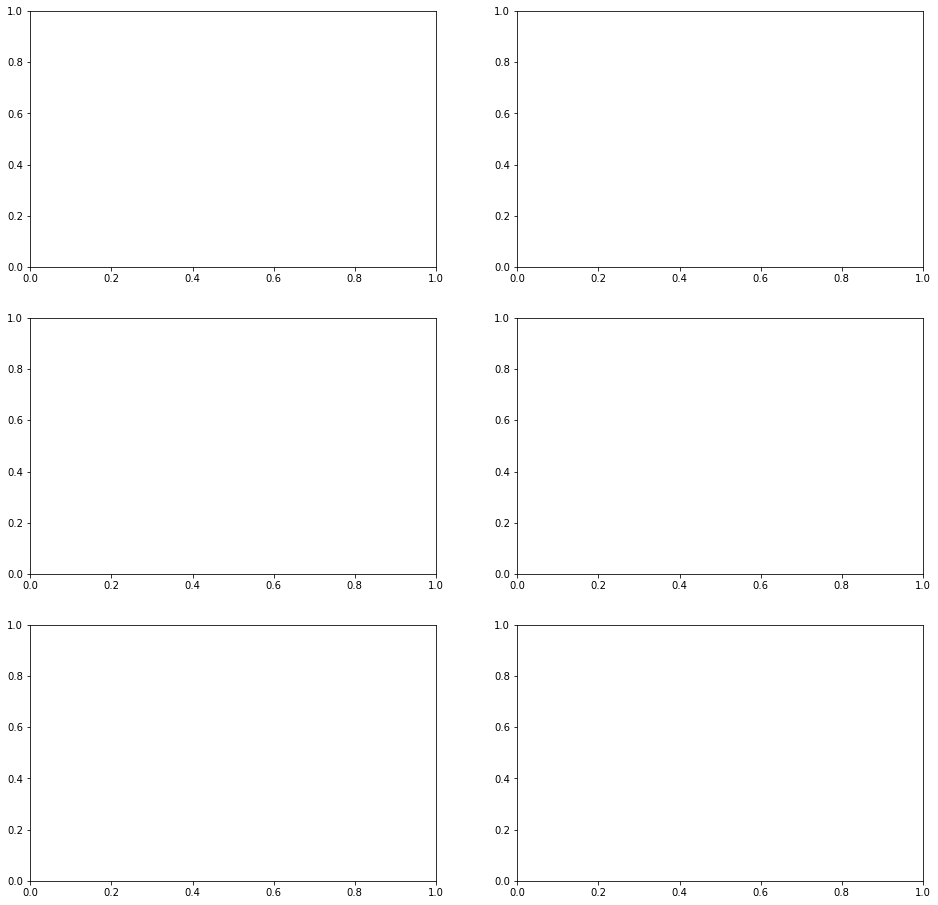

In [7]:
file1 = 'ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re.dat'
lead_names = ["i", "ii", "iii", "avr", "avl", "avf", "v1", "v2", "v3", "v4", "v5", "v6"]
sample_frequency = 1000 # Hz

#to be investigated
cut_off_freq = 40
order = 3

plot_raw_and_filtered(file1, lead_names, cut_off_freq, order, sample_frequency)
#do a power spectrum to see the frequencies expressed within the signals
#filter too strong

All six raw and filtered leads shown above.

The above data is for:
age: 81
sex: female
ECG date: 01/10/1990

Diagnose:
Reason for admission: Myocardial infarction





Below is an example of a healthy patient

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

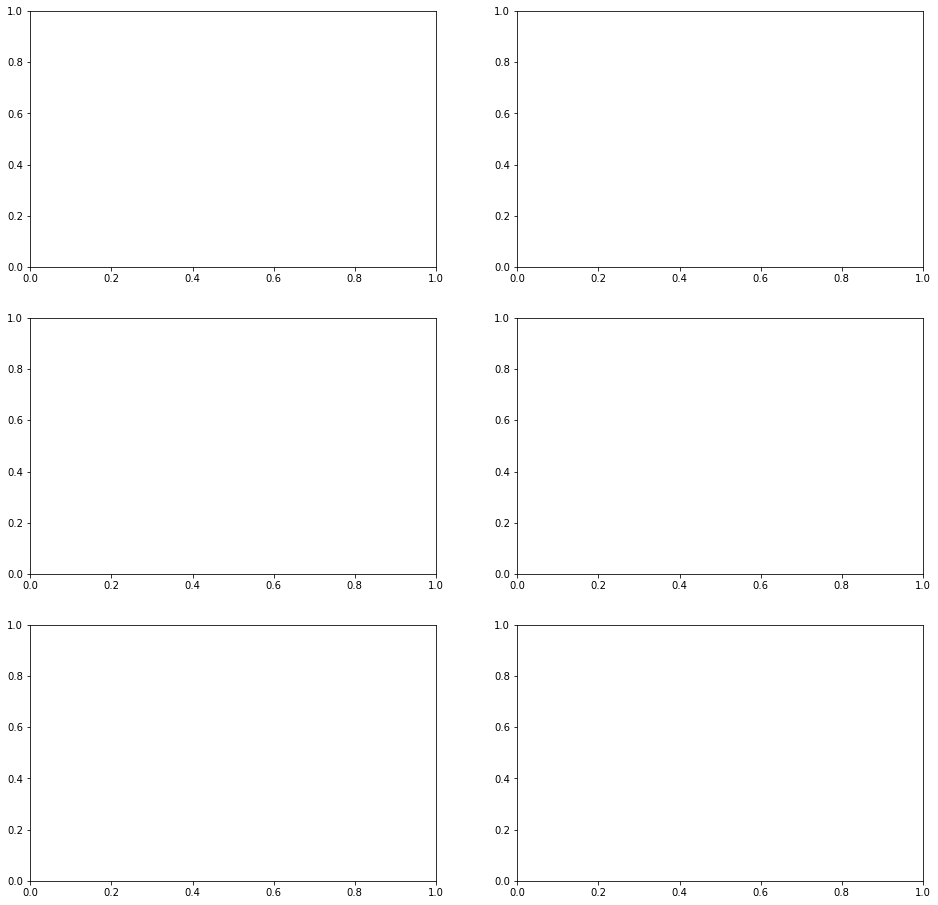

In [8]:
file2 = 'ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient117/s0291lre.dat'

plot_raw_and_filtered(file2, lead_names, cut_off_freq, order, sample_frequency)

age: 37
sex: male
ECG date: 07/04/1992

Diagnose:
Reason for admission: Healthy control

Below is another randomly chosen patient:

In [ ]:
file3 = 'ptb-diagnostic-ecg-database-1.0.0/ptb-diagnostic-ecg-database-1.0.0/patient125/s0006_re.dat'

plot_raw_and_filtered(file3, lead_names, cut_off_freq, order, sample_frequency)